## Imports

In [639]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder,MinMaxScaler,StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score,accuracy_score
from imblearn.over_sampling import SMOTENC,SMOTE
import warnings
import PySimpleGUI as sg
from joblib import dump, load
warnings.filterwarnings('ignore')

## Data Reading

In [640]:
df=pd.read_excel('Adult Census Income_Dataset.xlsx')                                                                                                                

In [641]:
df.to_csv('Adult Income New.csv')

In [642]:
df=pd.read_csv('Adult Income New.csv')

## Data Exploration

In [643]:
df.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [644]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      32561 non-null  int64 
 1   age             32561 non-null  int64 
 2   workclass       32561 non-null  object
 3   fnlwgt          32561 non-null  int64 
 4   education       32561 non-null  object
 5   education.num   32561 non-null  int64 
 6   marital.status  32561 non-null  object
 7   occupation      32561 non-null  object
 8   relationship    32561 non-null  object
 9   race            32561 non-null  object
 10  sex             32561 non-null  object
 11  capital.gain    32561 non-null  int64 
 12  capital.loss    32561 non-null  int64 
 13  hours.per.week  32561 non-null  int64 
 14  native.country  32561 non-null  object
 15  income          32561 non-null  object
dtypes: int64(7), object(9)
memory usage: 4.0+ MB


In [645]:
df.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,32561.0,16280.000000,9399.695394,0.0,8140.0,16280.0,24420.0,32560.0
age,32561.0,38.581647,13.640433,17.0,28.0,37.0,48.0,90.0
fnlwgt,32561.0,189778.366512,105549.977697,12285.0,117827.0,178356.0,237051.0,1484705.0
education.num,32561.0,10.080679,2.572720,1.0,9.0,10.0,12.0,16.0
capital.gain,32561.0,1077.648844,7385.292085,0.0,0.0,0.0,0.0,99999.0
capital.loss,32561.0,87.303830,402.960219,0.0,0.0,0.0,0.0,4356.0
hours.per.week,32561.0,40.437456,12.347429,1.0,40.0,40.0,45.0,99.0


In [646]:
print('Number of rows:', df.shape[0])

Number of rows: 32561


In [647]:
print('Number of columns:', df.shape[1])

Number of columns: 16


In [648]:
df['income']=df['income'].map({"<=50K":0,">50K":1})

<Axes: xlabel='income', ylabel='count'>

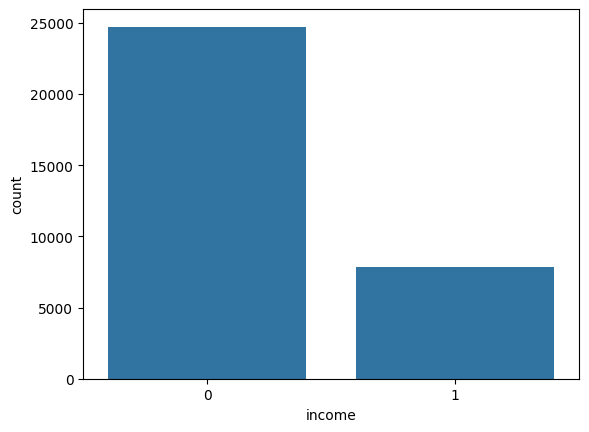

In [649]:
sns.countplot(x='income',data=df)

## Data Pre-Proccessing

### Duplicates

In [650]:
df.duplicated().sum()

0

### Clipping Outliers

In [651]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

data_without_outliers = df[(df['age'] >= lower_bound) & (df['age'] <= upper_bound)]

max_age = data_without_outliers['age'].max()
minAge=data_without_outliers['age'].min()
print(lower_bound)
print(upper_bound)

-2.0
78.0


In [652]:
a=df['age']
outliers = a[(a < lower_bound) | (a > upper_bound)]
len(outliers)

143

<Axes: ylabel='age'>

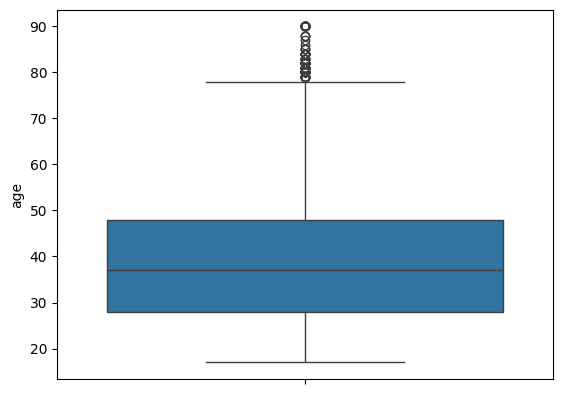

In [653]:
sns.boxplot(data = df, y = 'age')

In [654]:
df[df['age'] > upper_bound]['income'].value_counts()

income
0    118
1     25
Name: count, dtype: int64

In [655]:
df[df['age']< lower_bound]['income'].value_counts()

Series([], Name: count, dtype: int64)

In [656]:
df['age'] = df["age"].clip(lower=lower_bound,upper=upper_bound)

### Missing Data

In [657]:
columns=df.columns
df[columns]=df.replace('?',np.nan)

In [658]:
100*(df.isnull().sum()/len(df))

Unnamed: 0        0.000000
age               0.000000
workclass         5.638647
fnlwgt            0.000000
education         0.000000
education.num     0.000000
marital.status    0.000000
occupation        5.660146
relationship      0.000000
race              0.000000
sex               0.000000
capital.gain      0.000000
capital.loss      0.000000
hours.per.week    0.000000
native.country    1.790486
income            0.000000
dtype: float64

In [659]:
mode_nativecountry=df['native.country'].mode()[0]

In [660]:
df['workclass']=df['workclass'].fillna('Unemployed')
df['occupation']=df['occupation'].fillna('None')
df['native.country']=df['native.country'].fillna(mode_nativecountry)

In [661]:
df.isnull().sum()

Unnamed: 0        0
age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [662]:
df.head()

,Unnamed: 0,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,0,78,Unemployed,77053,HS-grad,9,Widowed,None,Not-in-family,White,Female,0,4356,40,United-States,0
1,1,78,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
2,2,66,Unemployed,186061,Some-college,10,Widowed,None,Unmarried,Black,Female,0,4356,40,United-States,0
3,3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0


In [663]:
df=df.drop("Unnamed: 0",axis=1)

In [664]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

In [665]:
df.corr(numeric_only=True)['income'].sort_values(ascending=False)

income            1.000000
education.num     0.335154
age               0.235865
hours.per.week    0.229689
capital.gain      0.223329
capital.loss      0.150526
fnlwgt           -0.009463
Name: income, dtype: float64

<Axes: >

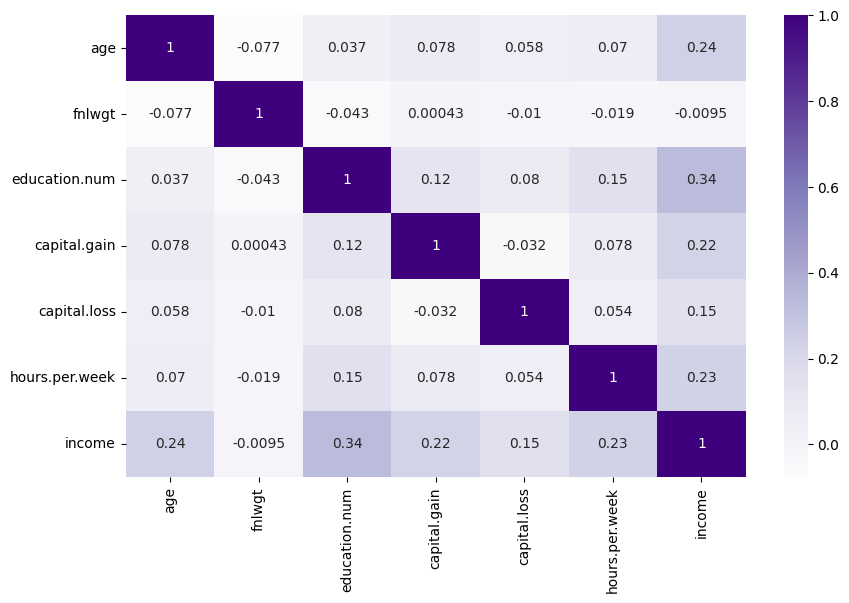

In [666]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True),annot=True,cmap='Purples')

## Feature Expansion

In [667]:
def ageGrouping(column):
    if column<= 30 & column>=17:
        return "Youth"
    elif column <= 50:
        return "Middle-aged"
    else:
        return "Senior"      

In [668]:
df['ageGroup'] = df['age'].apply(ageGrouping)

In [669]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,ageGroup
0,78,Unemployed,77053,HS-grad,9,Widowed,None,Not-in-family,White,Female,0,4356,40,United-States,0,Senior
1,78,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0,Senior
2,66,Unemployed,186061,Some-college,10,Widowed,None,Unmarried,Black,Female,0,4356,40,United-States,0,Senior
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0,Senior
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0,Middle-aged


In [670]:
df.tail()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,ageGroup
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,0,Youth
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0,Middle-aged
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1,Middle-aged
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0,Senior
32560,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0,Youth


In [671]:
df['net']=df['capital.gain']-df['capital.loss']

In [672]:
df["work_hours_per_age"] = df["hours.per.week"] / df["age"]  # Workload relative to age
df["hours_category"] = pd.cut(df["hours.per.week"], bins=[0, 30, 40, 60, 100], labels=["Part-time", "Full-time", "Overtime", "Extreme"])
df["family_structure"] = df["marital.status"] + "-" + df["relationship"]  # Combine marital and relationship

df["capital_activity"] = np.where((df["capital.gain"] > 0) | (df["capital.loss"] > 0), 1, 0)  # 0 if either capital gain or loss is 0, 1 otherwise

In [673]:
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,...,capital.loss,hours.per.week,native.country,income,ageGroup,net,work_hours_per_age,hours_category,family_structure,capital_activity
0,78,Unemployed,77053,HS-grad,9,Widowed,None,Not-in-family,White,Female,...,4356,40,United-States,0,Senior,-4356,0.512821,Full-time,Widowed-Not-in-family,1
1,78,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,...,4356,18,United-States,0,Senior,-4356,0.230769,Part-time,Widowed-Not-in-family,1
2,66,Unemployed,186061,Some-college,10,Widowed,None,Unmarried,Black,Female,...,4356,40,United-States,0,Senior,-4356,0.606061,Full-time,Widowed-Unmarried,1
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,...,3900,40,United-States,0,Senior,-3900,0.740741,Full-time,Divorced-Unmarried,1
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,...,3900,40,United-States,0,Middle-aged,-3900,0.975610,Full-time,Separated-Own-child,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,...,0,40,United-States,0,Youth,0,1.818182,Full-time,Never-married-Not-in-family,0
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,...,0,38,United-States,0,Middle-aged,0,1.407407,Full-time,Married-civ-spouse-Wife,0
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,...,0,40,United-States,1,Middle-aged,0,1.000000,Full-time,Married-civ-spouse-Husband,0
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,...,0,40,United-States,0,Senior,0,0.689655,Full-time,Widowed-Unmarried,0


In [674]:
educationOrder = ['Preschool','1st-4th','5th-6th','7th-8th','9th','10th','11th','12th','HS-grad','Some-college', 'Assoc-voc', 'Assoc-acdm','Bachelors', 'Masters', 'Doctorate','Prof-school']
ageGroupOrder=['Youth','Middle-aged','Senior']
hours_category_order=["Part-time", "Full-time", "Overtime", "Extreme"]

In [675]:
df['education'] = df['education'].astype(str)
df['ageGroup'] = df['ageGroup'].astype(str)
df['hours_category'] = df['hours_category'].astype(str)

# Initialize OrdinalEncoder with correct categories
ordinal_encoder = OrdinalEncoder(categories=[educationOrder, ageGroupOrder, hours_category_order])

# Fit and transform the specified columns
df[['education', 'ageGroup', 'hours_category']] = ordinal_encoder.fit_transform(
    df[['education', 'ageGroup', 'hours_category']]
).astype(int)

# Save the encoder
dump(ordinal_encoder, 'ordinal_encoder.joblib')

print(df[['education', 'ageGroup', 'hours_category']].head())

   education  ageGroup  hours_category
0          8         2               1
1          8         2               0
2          9         2               1
3          3         2               1
4          9         1               1


In [676]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,...,capital.loss,hours.per.week,native.country,income,ageGroup,net,work_hours_per_age,hours_category,family_structure,capital_activity
0,78,Unemployed,77053,8,9,Widowed,None,Not-in-family,White,Female,...,4356,40,United-States,0,2,-4356,0.512821,1,Widowed-Not-in-family,1
1,78,Private,132870,8,9,Widowed,Exec-managerial,Not-in-family,White,Female,...,4356,18,United-States,0,2,-4356,0.230769,0,Widowed-Not-in-family,1
2,66,Unemployed,186061,9,10,Widowed,None,Unmarried,Black,Female,...,4356,40,United-States,0,2,-4356,0.606061,1,Widowed-Unmarried,1
3,54,Private,140359,3,4,Divorced,Machine-op-inspct,Unmarried,White,Female,...,3900,40,United-States,0,2,-3900,0.740741,1,Divorced-Unmarried,1
4,41,Private,264663,9,10,Separated,Prof-specialty,Own-child,White,Female,...,3900,40,United-States,0,1,-3900,0.975610,1,Separated-Own-child,1


In [677]:
OneHotColumns=['workclass','marital.status','occupation','relationship','race','sex','native.country','family_structure']

df_encoded = pd.get_dummies(df[OneHotColumns], drop_first=True).astype(int)
df_remaining = df.drop(columns=OneHotColumns)
df = pd.concat([df_remaining, df_encoded], axis=1)

feature_order = df.columns.tolist()
feature_order.remove('income')
dump(feature_order, 'feature_order.joblib')

['feature_order.joblib']

In [678]:
"""columns_to_encode = ['education', 'ageGroup', 'workclass', 'marital.status', 
                     'occupation', 'relationship', 'race', 'sex', 'native.country']
for column in columns_to_encode:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])"""

"columns_to_encode = ['education', 'ageGroup', 'workclass', 'marital.status', \n                     'occupation', 'relationship', 'race', 'sex', 'native.country']\nfor column in columns_to_encode:\n    le = LabelEncoder()\n    df[column] = le.fit_transform(df[column])"

In [679]:
len(feature_order)   

118

In [680]:
file_path = r"my_dataframe.csv"

# Save the DataFrame to CSV with utf-8 encoding
df.to_csv(file_path, index=False, encoding='utf-8')

In [681]:
df.corr()['income'].sort_values(ascending=False)

income                                         1.000000
marital.status_Married-civ-spouse              0.444696
family_structure_Married-civ-spouse-Husband    0.400811
education                                      0.335951
education.num                                  0.335154
                                                 ...   
occupation_Other-service                      -0.156348
relationship_Not-in-family                    -0.188497
family_structure_Never-married-Own-child      -0.218014
relationship_Own-child                        -0.228532
marital.status_Never-married                  -0.318440
Name: income, Length: 119, dtype: float64

In [682]:
df[df["income"].isnull()]

,age,fnlwgt,education,education.num,capital.gain,capital.loss,hours.per.week,income,ageGroup,net,...,family_structure_Never-married-Own-child,family_structure_Never-married-Unmarried,family_structure_Separated-Not-in-family,family_structure_Separated-Other-relative,family_structure_Separated-Own-child,family_structure_Separated-Unmarried,family_structure_Widowed-Not-in-family,family_structure_Widowed-Other-relative,family_structure_Widowed-Own-child,family_structure_Widowed-Unmarried


## Machine Learning

### Data Splitting

In [683]:
X = df.drop(columns=['income'])
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Data Scaling

In [684]:
scaler=StandardScaler()
#scaler=MinMaxScaler()

X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)           

-0.4177738812247159 0.20926760150270984
Outliers: [ 1.43968989  0.96194408 -0.42031615 -0.42004043  1.61286334 -0.97776914
  0.66228123  1.0795882  -0.69344462  2.62995014 -0.58383528 -0.42751742
  0.41400919  0.70366585  0.3065632   1.2103991 ]
16
0.0491385399711311


<Axes: >

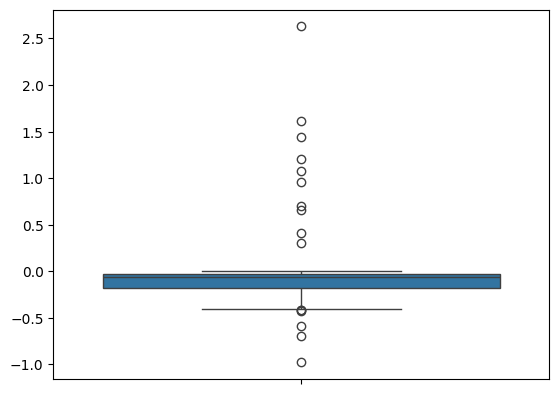

In [685]:
a = np.array(X_train[0])
Q1 = np.percentile(a, 25)
Q3 = np.percentile(a, 75)
IQR = Q3 - Q1

# Define the outlier range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(lower_bound, upper_bound)
# Find the outliers
outliers = a[(a < lower_bound) | (a > upper_bound)]
print("Outliers:", outliers)
print(len(outliers))
print(len(outliers)/df.shape[0] *100 )

sns.boxplot(a)

In [686]:
len(X_train)

22792

In [687]:
y_train.isnull().sum()

0

In [688]:
y_train.value_counts()

income
0    17291
1     5501
Name: count, dtype: int64

###  Handling Imbalance

In [689]:
"""import numpy as np
import pandas as pd
from sklearn.utils import resample

# Assuming X_train and y_train are already defined after train_test_split

# Check the current distribution of classes in y_train
print(f"Before oversampling:\n{y_train.value_counts()}")

# Separate the majority (0) and minority (1) classes
X_majority = X_train[y_train == 0]
y_majority = y_train[y_train == 0]
X_minority = X_train[y_train == 1]
y_minority = y_train[y_train == 1]

# Oversample the minority class to match the majority class
X_minority_oversampled, y_minority_oversampled = resample(
    X_minority, y_minority,
    replace=True,  # Sample with replacement
    n_samples=len(X_majority),  # Match the number of majority class
    random_state=42
)

# Combine the majority class with the oversampled minority class
X_train_res = np.vstack([X_majority, X_minority_oversampled])
y_train_res = np.concatenate([y_majority, y_minority_oversampled])

# Shuffle the resulting data
shuffle_index = np.random.permutation(len(X_train_res))
X_train_res, y_train_res = X_train_res[shuffle_index], y_train_res[shuffle_index]

# Check the new class distribution
print(f"After oversampling:\n{pd.Series(y_train_res).value_counts()}")"""


'import numpy as np\nimport pandas as pd\nfrom sklearn.utils import resample\n\n# Assuming X_train and y_train are already defined after train_test_split\n\n# Check the current distribution of classes in y_train\nprint(f"Before oversampling:\n{y_train.value_counts()}")\n\n# Separate the majority (0) and minority (1) classes\nX_majority = X_train[y_train == 0]\ny_majority = y_train[y_train == 0]\nX_minority = X_train[y_train == 1]\ny_minority = y_train[y_train == 1]\n\n# Oversample the minority class to match the majority class\nX_minority_oversampled, y_minority_oversampled = resample(\n    X_minority, y_minority,\n    replace=True,  # Sample with replacement\n    n_samples=len(X_majority),  # Match the number of majority class\n    random_state=42\n)\n\n# Combine the majority class with the oversampled minority class\nX_train_res = np.vstack([X_majority, X_minority_oversampled])\ny_train_res = np.concatenate([y_majority, y_minority_oversampled])\n\n# Shuffle the resulting data\nshuffl

In [690]:
#categorical_features = ['education', 'ageGroup']
from imblearn.over_sampling import BorderlineSMOTE,SVMSMOTE,KMeansSMOTE,ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek

smote_nc = SMOTE(random_state=42, k_neighbors=3, sampling_strategy=0.5)
X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)

resampled_data = pd.DataFrame(X_train_res, columns=X.columns)
resampled_data['income'] = y_train_res
resampled_data.to_csv("adult_income_resampled.csv",index=False)

In [691]:
X_train_res

array([[ 1.43968989,  0.96194408, -0.42031615, ..., -0.03865204,
        -0.0198754 , -0.10825318],
       [ 1.73590264, -0.76197267, -0.03417218, ..., -0.03865204,
        -0.0198754 , -0.10825318],
       [-0.41163981, -0.49914857,  1.12425973, ..., -0.03865204,
        -0.0198754 , -0.10825318],
       ...,
       [ 1.21753032,  2.58277914,  1.5104037 , ..., -0.03865204,
        -0.0198754 , -0.10825318],
       [-0.02082242, -1.03924504, -0.3131524 , ..., -0.03865204,
        -0.0198754 , -0.10825318],
       [ 1.09900977,  0.07070813,  1.48469158, ..., -0.03865204,
        -0.0198754 , -0.10825318]])

In [692]:
len(df)

32561

In [693]:
df['income'].value_counts()

income
0    24720
1     7841
Name: count, dtype: int64

In [694]:
len(X_train_res)

25936

In [695]:
y_train_res.value_counts()

income
0    17291
1     8645
Name: count, dtype: int64

### Logistic Regression

In [696]:
"""param_grid = {
    'C':np.logspace(-20,0,20),          # Regularization strength
    'solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg'],  # Solvers
    'penalty':['l2','l1']
}
log_model = GridSearchCV(estimator=LogisticRegression(max_iter=10000), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
log_model.fit(X_train_res,y_train_res)
print(log_model.best_params_)"""
#best param:1,liblinear,l2

log_model=LogisticRegression(C=1.0,solver='liblinear',penalty='l2')
log_model.fit(X_train_res,y_train_res)

y_pred_test=log_model.predict(X_test)
y_pred_train=log_model.predict(X_train_res)

print("Train Accuracy (Logisitc):", accuracy_score(y_train_res, y_pred_train))
print("Test Accuracy (Logistic):", accuracy_score(y_test, y_pred_test))

# Confusion Matrix, Classification Report, and ROC-AUC Score
confusion_log = confusion_matrix(y_test, y_pred_test )
report_log = classification_report(y_test, y_pred_test)
roc_score_log = roc_auc_score(y_test, y_pred_test)

print("\nConfusion Matrix (Logistic):\n", confusion_log)
print("\nClassification Report (Logistic):\n\n", report_log)
print("\nROC-AUC Score (Logistic):", roc_score_log)

dump(log_model,"logistic_model.joblib")

Train Accuracy (Logisitc): 0.8419956816779766
Test Accuracy (Logistic): 0.8510594738458389

Confusion Matrix (Logistic):
 [[6669  760]
 [ 695 1645]]

Classification Report (Logistic):

               precision    recall  f1-score   support

           0       0.91      0.90      0.90      7429
           1       0.68      0.70      0.69      2340

    accuracy                           0.85      9769
   macro avg       0.79      0.80      0.80      9769
weighted avg       0.85      0.85      0.85      9769


ROC-AUC Score (Logistic): 0.8003448313550615


['logistic_model.joblib']

### KNN

In [697]:
"""# Define the parameter grid
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']
}

# Initialize the KNN model
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train_res, y_train_res)

# Get the best parameters and best score
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

y_pred_test=grid_search.predict(X_test)
y_pred_train=grid_search.predict(X_train_res)

print("Train Accuracy (KNN):", accuracy_score(y_train_res, y_pred_train))
print("Test Accuracy (KNN):", accuracy_score(y_test, y_pred_test))

confusion_KNN = confusion_matrix(y_test, y_pred_test )
report_KNN = classification_report(y_test, y_pred_test)
roc_score_KNN = roc_auc_score(y_test, y_pred_test)

print("\nConfusion Matrix (KNN):\n", confusion_KNN)
print("\nClassification Report (KNN):\n\n", report_KNN)
print("\nROC-AUC Score (KNN):", roc_score_KNN)
"""

'# Define the parameter grid\nparam_grid = {\n    \'n_neighbors\': list(range(1, 31)),\n    \'metric\': [\'euclidean\', \'manhattan\', \'minkowski\'],\n    \'weights\': [\'uniform\', \'distance\']\n}\n\n# Initialize the KNN model\nknn = KNeighborsClassifier()\n\n# Initialize GridSearchCV\ngrid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring=\'precision\', n_jobs=-1, verbose=1)\n\n# Fit the grid search to the data\ngrid_search.fit(X_train_res, y_train_res)\n\n# Get the best parameters and best score\nbest_params = grid_search.best_params_\n\nprint("Best Parameters:", best_params)\n\ny_pred_test=grid_search.predict(X_test)\ny_pred_train=grid_search.predict(X_train_res)\n\nprint("Train Accuracy (KNN):", accuracy_score(y_train_res, y_pred_train))\nprint("Test Accuracy (KNN):", accuracy_score(y_test, y_pred_test))\n\nconfusion_KNN = confusion_matrix(y_test, y_pred_test )\nreport_KNN = classification_report(y_test, y_pred_test)\nroc_score_KNN = roc_auc_score(y_test,

In [ ]:
test_accuracy = []
train_accuracy = []
Gap= []
for d in range(1, 31):
    model = KNeighborsClassifier(n_neighbors=d,metric='manhattan')
    model.fit(X_train_res, y_train_res)

    y_pred_train = model.predict(X_train_res)
    y_pred_test = model.predict(X_test)
    
   
    train_accuracy.append(accuracy_score(y_train_res, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))
    Gap.append(accuracy_score(y_train_res, y_pred_train) - accuracy_score(y_test, y_pred_test) )
    
best_min = min(Gap)
best_k = Gap.index(best_min)+1
print(best_k)

Bets k:26

In [698]:
#knn_model=KNeighborsClassifier(n_neighbors=28,metric='minkowski')
knn_model = KNeighborsClassifier(n_neighbors=28, metric='manhattan')


knn_model.fit(X_train_res,y_train_res)

y_pred_test=knn_model.predict(X_test)
y_pred_train=knn_model.predict(X_train_res)


print("Train Accuracy (KNN):", accuracy_score(y_train_res, y_pred_train))
print("Test Accuracy (KNN):", accuracy_score(y_test, y_pred_test))


confusion_KNN = confusion_matrix(y_test, y_pred_test )
report_KNN = classification_report(y_test, y_pred_test)
roc_score_KNN = roc_auc_score(y_test, y_pred_test)

print("\nConfusion Matrix (KNN):\n", confusion_KNN)

print("\nClassification Report (KNN):\n\n", report_KNN)
print("\nROC-AUC Score (KNN):", roc_score_KNN)

dump(knn_model,"knn_model.joblib")

Train Accuracy (KNN): 0.8356338679827268
Test Accuracy (KNN): 0.8368307912785341

Confusion Matrix (KNN):
 [[6554  875]
 [ 719 1621]]

Classification Report (KNN):

               precision    recall  f1-score   support

           0       0.90      0.88      0.89      7429
           1       0.65      0.69      0.67      2340

    accuracy                           0.84      9769
   macro avg       0.78      0.79      0.78      9769
weighted avg       0.84      0.84      0.84      9769


ROC-AUC Score (KNN): 0.7874766881463611


['knn_model.joblib']

### Decision Tree

In [699]:
""""param_grid = {
    'max_depth': [None, 10, 20, 30,40],
    'min_samples_split': [2,5,8,10,13,15,19],
    'min_samples_leaf': [1,2,3,4,5,6,7,8],
    'criterion': ['gini', 'entropy','log_loss']  # Criterion to measure the quality of a split
}

DT_model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1,verbose=1)"""

#bestparam: criterion='entropy',max_depth=10,min_samples_split=12,min_samples_leaf=10)

DT_model=DecisionTreeClassifier(criterion='entropy',max_depth=10,min_samples_split=12,min_samples_leaf=10)
DT_model.fit(X_train_res,y_train_res)

#grid_model.fit(X_train_res, y_train_res)
#DT_model = grid_model.best_estimator_

y_pred_test=DT_model.predict(X_test)
y_pred_train=DT_model.predict(X_train_res)

print("Train Accuracy (DT):", accuracy_score(y_train_res, y_pred_train))
print("Test Accuracy (DT):", accuracy_score(y_test, y_pred_test))

confusion_DT = confusion_matrix(y_test, y_pred_test )
report_DT = classification_report(y_test, y_pred_test)
roc_score_DT = roc_auc_score(y_test, y_pred_test)

print("\nConfusion Matrix (DT):\n", confusion_DT)
print("\nClassification Report (DT):\n\n", report_DT)
print("\nROC-AUC Score (DT):", roc_score_DT)
dump(DT_model,'DT_model.joblib')

Train Accuracy (DT): 0.8512106724244294
Test Accuracy (DT): 0.8462483365748797

Confusion Matrix (DT):
 [[6687  742]
 [ 760 1580]]

Classification Report (DT):

               precision    recall  f1-score   support

           0       0.90      0.90      0.90      7429
           1       0.68      0.68      0.68      2340

    accuracy                           0.85      9769
   macro avg       0.79      0.79      0.79      9769
weighted avg       0.85      0.85      0.85      9769


ROC-AUC Score (DT): 0.7876674110352937


['DT_model.joblib']

### Support Vector Machine

In [700]:
'''param_grid = {
    'kernel': ['linear', 'rbf', 'poly','sigmoid'],
    'C': [0.1,1,10,100,1000],
    'gamma': ['scale', 'auto']  
}
grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose = 1)'''

svm=SVC(kernel='rbf',C=0.1,gamma='scale')

svm.fit(X_train_res, y_train_res)
y_pred_test=svm.predict(X_test)
y_pred_train=svm.predict(X_train_res)

print("Train Accuracy (SVM):", accuracy_score(y_train_res, y_pred_train))
print("Test Accuracy (SVM):", accuracy_score(y_test, y_pred_test))

confusion_SVM = confusion_matrix(y_test, y_pred_test )
report_SVM = classification_report(y_test, y_pred_test)
roc_score_SVM = roc_auc_score(y_test, y_pred_test)

print("\nConfusion Matrix (SVM):\n", confusion_SVM)
print("\nClassification Report (SVM):\n\n", report_SVM)
print("\nROC-AUC Score (SVM):", roc_score_SVM)

dump(svm,'SVM.joblib')

Train Accuracy (SVM): 0.8256863047501543
Test Accuracy (SVM): 0.8418466577950661

Confusion Matrix (SVM):
 [[6707  722]
 [ 823 1517]]

Classification Report (SVM):

               precision    recall  f1-score   support

           0       0.89      0.90      0.90      7429
           1       0.68      0.65      0.66      2340

    accuracy                           0.84      9769
   macro avg       0.78      0.78      0.78      9769
weighted avg       0.84      0.84      0.84      9769


ROC-AUC Score (SVM): 0.7755519487616674


['SVM.joblib']

### Ada Boost

In [701]:
"""param_grid_adaboost = {
    'n_estimators': list(range(100,200)),  
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}
adaboost_model = GridSearchCV(estimator=AdaBoostClassifier(),param_grid=param_grid_adaboost,cv=5,scoring='accuracy',n_jobs=-1)"""

adaboost_model=AdaBoostClassifier(learning_rate=1,n_estimators=150)
adaboost_model.fit(X_train_res, y_train_res)

y_pred_test_adaboost = adaboost_model.predict(X_test)
y_pred_train_adaboost = adaboost_model.predict(X_train_res)

print("Train Accuracy (AdaBoost):", accuracy_score(y_train_res, y_pred_train_adaboost))
print("Test Accuracy (AdaBoost):", accuracy_score(y_test, y_pred_test_adaboost))

confusion_ada = confusion_matrix(y_test, y_pred_test_adaboost)
report_ada = classification_report(y_test, y_pred_test_adaboost)
roc_score_ada = roc_auc_score(y_test, y_pred_test_adaboost)

print("\nConfusion Matrix (AdaBoost):\n", confusion_ada)
print("\nClassification Report (AdaBoost):\n", report_ada)
print("\nROC-AUC Score (AdaBoost):", roc_score_ada)
dump(adaboost_model,'adaboost_model.joblib')

Train Accuracy (AdaBoost): 0.8564543491671808
Test Accuracy (AdaBoost): 0.8626266762206981

Confusion Matrix (AdaBoost):
 [[6800  629]
 [ 713 1627]]

Classification Report (AdaBoost):
               precision    recall  f1-score   support

           0       0.91      0.92      0.91      7429
           1       0.72      0.70      0.71      2340

    accuracy                           0.86      9769
   macro avg       0.81      0.81      0.81      9769
weighted avg       0.86      0.86      0.86      9769


ROC-AUC Score (AdaBoost): 0.8053154765397328


['adaboost_model.joblib']

In [669]:
adaboost_model.best_params_

AttributeError: 'AdaBoostClassifier' object has no attribute 'best_params_'

## EDA

<Axes: xlabel='age', ylabel='Density'>

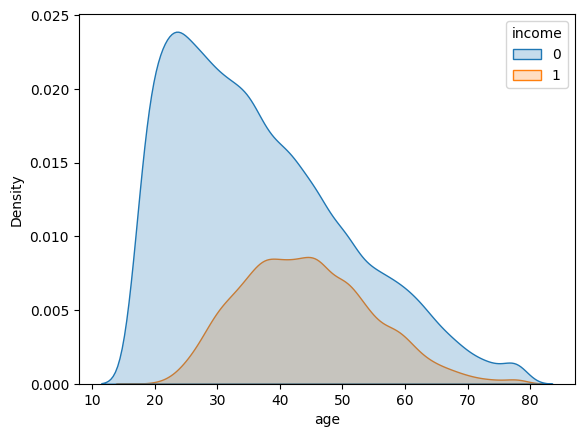

In [702]:
sns.kdeplot(x='age',data=df,hue='income',fill=True)

<Axes: xlabel='education.num', ylabel='count'>

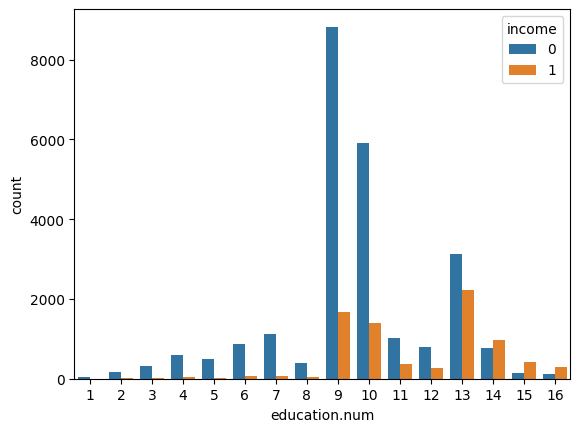

In [703]:
sns.countplot(data=df,x='education.num',hue='income')

<Axes: xlabel='capital.loss', ylabel='age'>

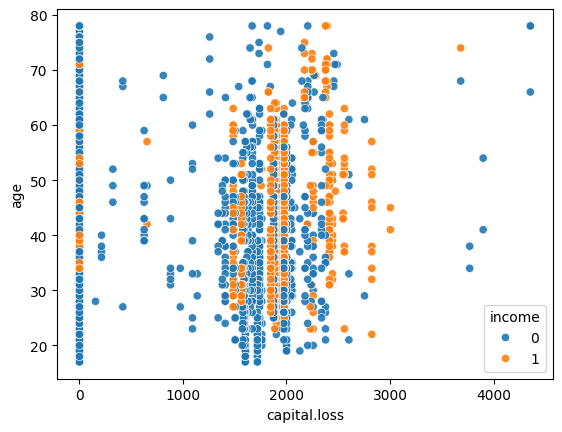

In [704]:
sns.scatterplot(x='capital.loss',y='age',data=df,hue='income',alpha=0.9)

## GUI

In [708]:
df_input_encoded=0

In [709]:
def model_load(model_name):
    model = load(model_name+'.joblib')
    y_pred_test = model.predict(X_test)
    
    confusion = confusion_matrix(y_test, y_pred_test)
    report = classification_report(y_test, y_pred_test)
    ROCscore = roc_auc_score(y_test, y_pred_test)
    
    return confusion, report, ROCscore
def ageGrouping(column):
    if 17 <= column <= 30:
        return "Youth"
    elif column <= 50:
        return "Middle-aged"
    else:
        return "Senior" 

def prepare_input_data(input_data):

    # Convert input to dataframe
    df_input = pd.DataFrame([input_data])
    
    # Load saved encoders
    ordinal_encoder = load('ordinal_encoder.joblib')
    feature_order = load('feature_order.joblib')

    df_input['ageGroup'] = df_input['age'].apply(ageGrouping)
    df_input['net'] = df_input['capital.gain'] - df_input['capital.loss']
    df_input["work_hours_per_age"] = df_input["hours.per.week"] / df_input["age"]
    df_input["hours_category"] = pd.cut(df_input["hours.per.week"], bins=[0, 30, 40, 60, 100], labels=["Part-time", "Full-time", "Overtime", "Extreme"])
    df_input["family_structure"] = df_input["marital.status"] + "-" + df_input["relationship"]
    df_input["capital_activity"] = np.where((df_input["capital.gain"] > 0) | (df_input["capital.loss"] > 0), 1, 0)

    # Apply ordinal encoding
    df_input[['education', 'ageGroup','hours_category']] = ordinal_encoder.transform(df_input[['education', 'ageGroup','hours_category']]).astype(int)
    
    # Apply one-hot encoding using pd.get_dummies
    OneHotColumns = ['workclass', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country','family_structure']
    df_input_encoded = pd.get_dummies(df_input, columns=OneHotColumns, drop_first=True).astype(int)
    
    # Ensure columns are in the same order as training data
    df_input_encoded = df_input_encoded.reindex(columns=feature_order, fill_value=0)
    
    return df_input_encoded,feature_order

In [710]:
FILE_PATH = r"my_dataframe.csv"
# 1. Dataset Loading
def load_dataset(file_path):
    global df, X_train, y_train, feature_columns
    try:
        df = pd.read_csv(file_path)
        print("Dataset loaded successfully!")
        return True
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return False

# 2. Model Selection
def load_model(model_name):
    if model_name == "Logistic Regression":
        model = load('logistic_model.joblib')
    elif model_name == "Decision Tree":
        model = load('DT_model.joblib')
    elif model_name == "KNN":
        model = load('knn_model.joblib')
    elif model_name == "SVM":
        model = load('SVM.joblib')
    elif model_name == "Ada Boost":
        model = load('adaboost_model.joblib')
    return model

# 3. Prediction with Model
def predict_with_loaded_model(model_name, user_input_data):
    try:
        # Load the trained model
        model = load_model(model_name)  
        # Align user input data with training data features
        user_input_data=user_input_data.to_numpy()
        user_input_data=scaler.transform(user_input_data)
        # Make prediction
        prediction = model.predict(user_input_data)

        return prediction
    except Exception as e:

        print(f"Error during prediction: {e}")
        return None

# Dataset Loading Window
def dataset_loader_window():
    layout = [
        [sg.Text("Load Your Dataset", font=("Helvetica", 14))],
        [sg.Input(default_text=r"my_dataframe.csv", key="-FILE-", size=(70, 1))],
        [sg.FileBrowse(file_types=(("CSV Files", "*.csv"),))],
        [sg.Button("Load Dataset"), sg.Button("Exit")]
    ]
    return sg.Window("Load Dataset", layout, finalize=True, resizable=True)

# Model Selection Window
def model_selection_window():
    layout = [
        [sg.Text("Select a Model", font=("Helvetica", 14))],
        [sg.Combo(["Logistic Regression", "KNN", "Decision Tree", "SVM","Ada Boost"], key="-MODEL-", size=(20, 1))],
        [sg.Button("Train Model"), sg.Button("Predict"), sg.Button("Back")],
        [sg.Text("Results:", font=("Helvetica", 12))],
        [sg.Multiline(size=(70, 20), key="-RESULTS-", disabled=True)]  # Placeholder for displaying results
    ]
    return sg.Window("Model Selection", layout, finalize=True)

# Prediction Input Window
def prediction_input_window():
    layout = [
        [sg.Text("Enter feature values for prediction:")],
        [sg.Text("Age:"), sg.InputText(key="age")],
        [sg.Text("Workclass:"), sg.InputText(key="workclass")],
        [sg.Text("Fnlwgt:"), sg.InputText(key="fnlwgt")],
        [sg.Text("Education:"), sg.InputText(key="education")],
        [sg.Text("Education Number:"), sg.InputText(key="education.num")],
        [sg.Text("Marital Status:"), sg.InputText(key="marital.status")],
        [sg.Text("Occupation:"), sg.InputText(key="occupation")],
        [sg.Text("Relationship:"), sg.InputText(key="relationship")],
        [sg.Text("Race:"), sg.InputText(key="race")],
        [sg.Text("Sex:"), sg.InputText(key="sex")],
        [sg.Text("Capital Gain:"), sg.InputText(key="capital.gain")],
        [sg.Text("Capital Loss:"), sg.InputText(key="capital.loss")],
        [sg.Text("Hours per Week:"), sg.InputText(key="hours.per.week")],
        [sg.Text("Native Country:"), sg.InputText(key="native.country")],
        [sg.Button("Predict"), sg.Button("Back")]
    ]
    return sg.Window("Prediction Input", layout, finalize=True)

# Main Event Loop
def main():
    window1 = dataset_loader_window()
    window2 = None
    window3 = None

    while True:
        window, event, values = sg.read_all_windows()

        if event == sg.WINDOW_CLOSED or event == "Exit":
            if window:
                window.close()
            if window == window1:
                window1 = None
                break
            elif window == window2:
                window2 = None
            elif window == window3:
                window3 = None

        # Dataset Loader logic
        if window == window1:
            if event == "Load Dataset":
                file_path = r"my_dataframe.csv"
                if load_dataset(file_path):
                    sg.popup("Dataset loaded successfully!")
                    window1.close()
                    window1 = None
                    window2 = model_selection_window()  # Show model selection window
                else:
                    sg.popup_error("Failed to load dataset!")

        # Model Selection logic
        if window == window2:
            if event == "Train Model":
                selected_model = values["-MODEL-"]
                if not selected_model:
                    sg.popup_error("Please select a model!")
                else:
                    if selected_model == "Logistic Regression":
                        confusion, class_report, accuracy = model_load('logistic_model')
                        results_text = (
                            f"Confusion Matrix:\n{confusion}\n\n"
                            f"Classification Report:\n{class_report}\n\n"
                            f"ROC Score: {accuracy}\n"
                        )
                    elif selected_model == "KNN":
                        confusionknn, class_reportknn, ROCscoreknn = model_load('knn_model')
                        results_text = (
                            f"Confusion Matrix:\n{confusionknn}\n\n"
                            f"Classification Report:\n{class_reportknn}\n\n"
                            f"ROC Score: {ROCscoreknn}\n"
                        )
                    elif selected_model == "Decision Tree":
                        confusiontree, class_reporttree, ROCscoretree = model_load('DT_model')
                        results_text = (
                            f"Confusion Matrix:\n{confusiontree}\n\n"
                            f"Classification Report:\n{class_reporttree}\n\n"
                            f"ROC Score: {ROCscoretree}\n"
                        )
                    elif selected_model == "SVM":
                        confusionSVM, class_reportSVM, ROCscoreSVM = model_load('SVM')
                        results_text = (
                            f"Confusion Matrix:\n{confusionSVM}\n\n"
                            f"Classification Report:\n{class_reportSVM}\n\n"
                            f"ROC Score: {ROCscoreSVM}\n"
                        )
                    elif selected_model == "Ada Boost":
                        confusionada, class_reportada, ROCscoreada = model_load('adaboost_model')
                        results_text = (
                            f"Confusion Matrix:\n{confusionada}\n\n"
                            f"Classification Report:\n{class_reportada}\n\n"
                            f"ROC Score: {ROCscoreada}\n"
                        )

                    window2["-RESULTS-"].update(results_text)  # Display the results

            elif event == "Back":
                window2.close()
                window2 = None
                window1 = dataset_loader_window()

            elif event == "Predict":
                selected_model = values.get("-MODEL-")
                if not selected_model:
                    sg.popup_error("Please select a model first!")
                else:
                    window2.hide()
                    window3 = prediction_input_window()

        # Prediction Input logic
        if window == window3:
            if event == "Back":
                window3.close()
                window3 = None
                window2.un_hide()

            elif event == "Predict":
                try:
                    # Collect user input data from the form
                    user_input_data = {
                        'age': float(values["age"]),
                        'workclass': values["workclass"],
                        'fnlwgt': float(values["fnlwgt"]),
                        'education': values["education"],
                        'education.num': int(values["education.num"]),
                        'marital.status': values["marital.status"],
                        'occupation': values["occupation"],
                        'relationship': values["relationship"],
                        'race': values["race"],
                        'sex': values["sex"],
                        'capital.gain': float(values["capital.gain"]),
                        'capital.loss': float(values["capital.loss"]),
                        'hours.per.week': float(values["hours.per.week"]),
                        'native.country': values["native.country"]
                    }

                    input_df,feature_order = prepare_input_data(user_input_data)
                    print(input_df.columns)   

                    prediction = predict_with_loaded_model(selected_model, input_df)
                    if prediction is not None:
                        if prediction[0]==1:
                            sg.popup(f"Predicted Income: >50K")
                        else:
                            sg.popup(f"Predicted Income: <=50K")
                    else:
                        sg.popup_error("Prediction failed. Please check your inputs and try again.")

                except Exception as e:
                    sg.popup_error(f"Error during prediction: {e}")

if __name__ == "__main__":
  main()

Dataset loaded successfully!
Index(['age', 'fnlwgt', 'education', 'education.num', 'capital.gain',
       'capital.loss', 'hours.per.week', 'ageGroup', 'net',
       'work_hours_per_age',
       ...
       'family_structure_Never-married-Own-child',
       'family_structure_Never-married-Unmarried',
       'family_structure_Separated-Not-in-family',
       'family_structure_Separated-Other-relative',
       'family_structure_Separated-Own-child',
       'family_structure_Separated-Unmarried',
       'family_structure_Widowed-Not-in-family',
       'family_structure_Widowed-Other-relative',
       'family_structure_Widowed-Own-child',
       'family_structure_Widowed-Unmarried'],
      dtype='object', length=118)


KeyboardInterrupt: 